# <p style="background-color:#b7c5f1;font-family:newtimeroman;color:#3f475e;font-size:150%;text-align:center;border-radius:30px 30px;">Melbourne Real Estate Prices</p>

<p align="center">
  <img src="https://reporter.mk/wp-content/uploads/2023/04/1681715037-shutterstock_1025960785-750x421-1.jpg" width="700"/>
</p>

## 1. Imports
---

In [192]:
import pandas as pd
from catboost import CatBoostRegressor, Pool, cv
import seaborn as sns
import phik
import shap

shap.initjs()

In [193]:
custom_palette = [
    "#b7c5f1",
    "#eebebe",
    "#f4b8e4",
    "#ca9ee6",
    "#e78284",
    "#ea999c",
    "#ef9f76",
    "#e5c890",
    "#a6d189",
    "#81c8be",
    "#99d1db",
    "#85c1dc",
    "#8caaee",
    "#babbf1",
    "#f3e1d6",
    "#f7ccc5",
    "#f7e1f0",
    "#dbc6f2",
    "#e89a9a",
    "#edb3b6",
    "#f5bda1",
    "#f1d2aa",
    "#c7e3af",
    "#a5dcd0",
    "#c2e7ec",
    "#b4d5e5",
    "#b7c5f1",
    "#d4d5f8",
    "#f1dad0",
    "#f6d3cb",
    "#fae2de",
    "#c3a2de",
    "#f0c4cf",
    "#f7bfdf",
    "#e2b3f7",
    "#fac7ba",
    "#cfd8a8",
]

In [194]:
from matplotlib.colors import LinearSegmentedColormap

colors = ["#b4befe", "#d0e2f2", "#f5e0dc", "#f7b7a3"]
cmap = LinearSegmentedColormap.from_list("pastel_gradient", colors, N=50)
sns.set(style="whitegrid", palette=custom_palette)

## 2. EDA Cleaning and Filling
---

In [195]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [196]:
len(train)

18373

In [197]:
len(test)

8818

<Axes: xlabel='Price', ylabel='Count'>

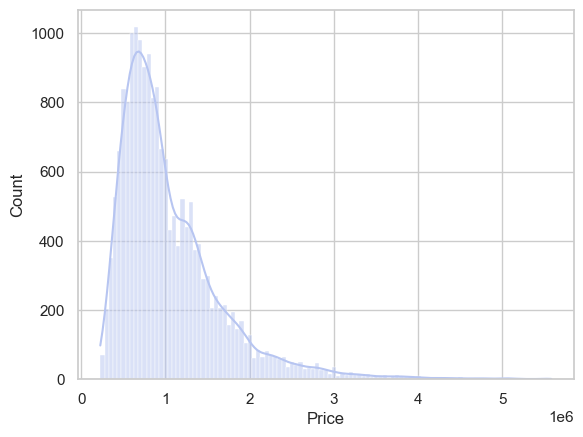

In [198]:
sns.histplot(train["Price"], kde=True)

In [199]:
# соединю трейн и тест для eda, потом, при обучении модели, я разделю их обратно

# добавляем флаг, чтобы потом разделить данные обратно
train["is_train"] = 1
test["is_train"] = 0

# добавляем колонку Price в test, заполняя ее NaN
test["Price"] = 0

# объединяем данные
df = pd.concat([train, test], ignore_index=True)


# TODO: После анализа разделяем данные обратно
# train_new = combined[combined["is_train"] == 1].drop(columns=["is_train"])
# test_new = combined[combined["is_train"] == 0].drop(columns=["is_train", "Price"])

In [200]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,is_train
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0,34302,1
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0,33247,1
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0,31886,1
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0,18999,1
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0,16809,1


In [201]:
df.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,id,is_train
count,27191.000000,2.719100e+04,27190.000000,27190.000000,20763.000000,20757.000000,20380.000000,17944.000000,10632.000000,12056.000000,20949.000000,20949.000000,27188.000000,27191.000000,27191.000000
mean,2.992681,7.116724e+05,11.289283,3113.839794,3.046670,1.590981,1.715604,593.412227,156.689808,1966.654778,-37.806935,144.996781,7567.178277,17427.445993,0.675702
std,0.952408,7.101638e+05,6.789767,111.207454,0.952635,0.699070,0.993517,3761.108988,449.642312,36.725334,0.091690,0.120741,4491.421957,10054.412391,0.468121
min,1.000000,0.000000e+00,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.190430,144.423790,83.000000,1.000000,0.000000
25%,2.000000,0.000000e+00,6.400000,3046.000000,2.000000,1.000000,1.000000,219.000000,100.000000,1950.000000,-37.861000,144.925390,4294.000000,8704.500000,0.000000
50%,3.000000,6.440000e+05,10.500000,3088.000000,3.000000,1.000000,2.000000,512.000000,133.000000,1970.000000,-37.800400,145.003300,6567.000000,17434.000000,1.000000
75%,4.000000,1.064000e+06,14.000000,3153.000000,4.000000,2.000000,2.000000,663.000000,181.000000,2000.000000,-37.748860,145.068800,10412.000000,26173.000000,1.000000
max,16.000000,5.580000e+06,48.100000,3978.000000,20.000000,9.000000,18.000000,433014.000000,44515.000000,2019.000000,-37.397800,145.526350,21650.000000,34856.000000,1.000000


In [202]:
df.isna().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price                0
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          6428
Bathroom          6434
Car               6811
Landsize          9247
BuildingArea     16559
YearBuilt        15135
CouncilArea          3
Lattitude         6242
Longtitude        6242
Regionname           3
Propertycount        3
id                   0
is_train             0
dtype: int64

In [203]:
df.isna().mean()

Suburb           0.000000
Address          0.000000
Rooms            0.000000
Type             0.000000
Price            0.000000
Method           0.000000
SellerG          0.000000
Date             0.000000
Distance         0.000037
Postcode         0.000037
Bedroom2         0.236402
Bathroom         0.236622
Car              0.250487
Landsize         0.340076
BuildingArea     0.608988
YearBuilt        0.556618
CouncilArea      0.000110
Lattitude        0.229561
Longtitude       0.229561
Regionname       0.000110
Propertycount    0.000110
id               0.000000
is_train         0.000000
dtype: float64

In [204]:
len(df)

27191

In [205]:
# нужно заполинть чем-то пропуски в колонках -
# Bedroom2          6428
# Bathroom          6434
# Car               6811
# Landsize          9247
# BuildingArea     16559
# YearBuilt        15135

# особенно меня беспокоят
# BuildingArea     0.608988
# YearBuilt        0.556618
# пропусков в них больше половины

# широту и долготу в будущем мы просто дропнем

# но пройдемся по всем колонкам

#### 1. Suburb - район

In [206]:
df["Suburb"].describe()

count         27191
unique          345
top       Reservoir
freq            725
Name: Suburb, dtype: object

/var/folders/sr/p3kpr51n4hs1q5w3zd7p_j0c0000gn/T/ipykernel_26624/4014438347.py:5: UserWarning: 
The palette list has fewer values (37) than needed (345) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


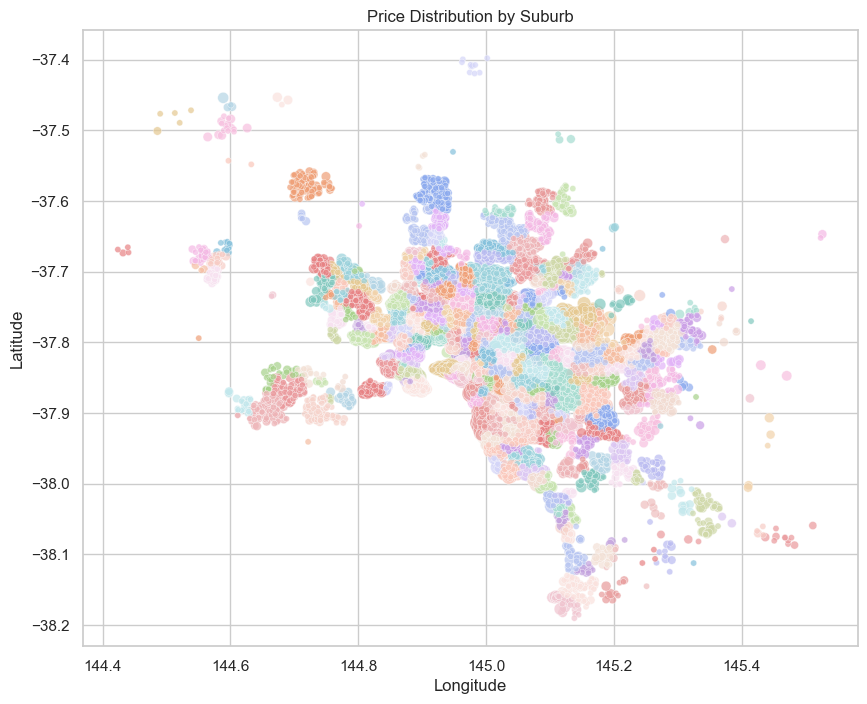

In [207]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

sns.scatterplot(
    x="Longtitude",
    y="Lattitude",
    size="Price",
    sizes=(20, 200),
    hue="Suburb",
    data=df,
    legend=False,
    alpha=0.7,
    palette=custom_palette,
)

plt.title("Price Distribution by Suburb")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Показываем график
plt.show()

In [208]:
categorial = ["Suburb"]

#### 2.Address

In [209]:
len(df["Address"].unique())

26696

In [210]:
# у нас очень много значений, может, есть смысл убрать номер дома и оставить только улицу

In [211]:
import re


def extract_street(address):
    match = re.search(r"\d+\s+(.*)", address)
    if match:
        return match.group(1)
    return address


df["Street"] = df["Address"].apply(extract_street)

len(df["Street"].unique())

10668

In [212]:
# думаю, что можно исключить эту колонку
columns_to_drop = ["Address"]
columns_to_drop = ["Street"]

#### 3. Rooms

In [213]:
df["Rooms"].value_counts()

Rooms
3     11952
2      6786
4      5906
5      1198
1      1171
6       135
7        20
8        14
10        5
12        2
9         1
16        1
Name: count, dtype: int64

In [214]:
df["Rooms"].describe()

count    27191.000000
mean         2.992681
std          0.952408
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         16.000000
Name: Rooms, dtype: float64

<Axes: >

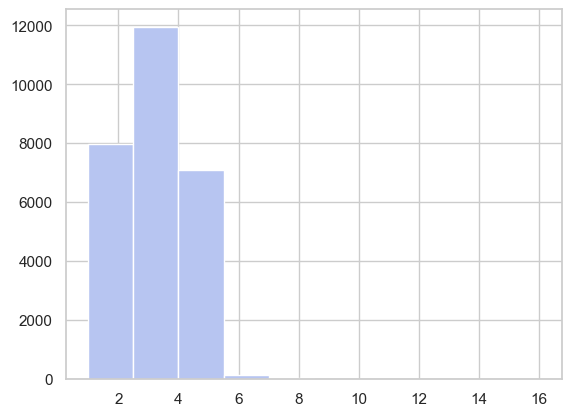

In [215]:
df["Rooms"].hist()

In [216]:
# попробую создать дополнительную фичу с комнатами - категории, а исходный столбец будет числовой
bins = [0, 1, 2, 3, 4, 5, float("inf")]
labels = [
    "1 room",
    "2 rooms",
    "3 rooms",
    "4 rooms",
    "5 rooms",
    "More than 5 rooms",
]
df["Rooms_Group"] = pd.cut(df["Rooms"], bins=bins, labels=labels, right=True)

In [217]:
categorial.append("Rooms_Group")
numerical = ["Rooms"]

#### 4. Type

In [218]:
df["Type"].describe()

count     27191
unique        3
top           h
freq      18443
Name: Type, dtype: object

<Axes: xlabel='Type', ylabel='Count'>

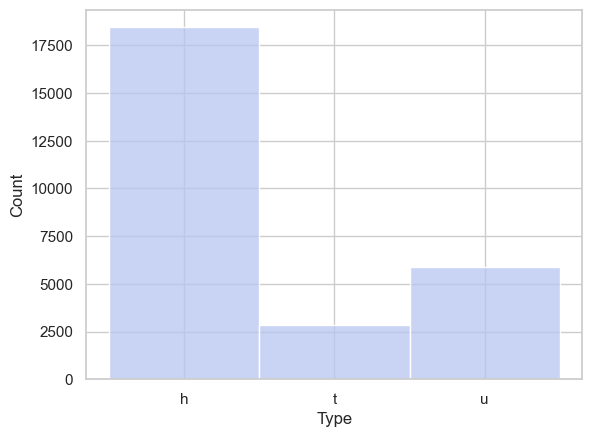

In [219]:
sns.histplot(df["Type"], kde=False)

In [220]:
# преимущественно тип - house
categorial.append("Type")

In [221]:
categorial

['Suburb', 'Rooms_Group', 'Type']

#### 5. Method

In [222]:
# у меня есть предположение, что метод продажи не слишком полезен при оценке стоимости, я думаю можно исключить эту фичу, или попробовать обучить модель с ней и без нее
# пока я думаю ее исключит

In [223]:
# фи квадрат показывает небольшую корреляцию
phik_corr = df[["Method", "Price"]].phik_matrix()
print(phik_corr)

interval columns not set, guessing: ['Price']
          Method     Price
Method  1.000000  0.154501
Price   0.154501  1.000000


In [224]:
columns_to_drop.append("Method")

In [225]:
columns_to_drop

['Street', 'Method']

#### 6. SellerG

In [226]:
len(df["SellerG"].unique())

349

In [227]:
sales_by_realtor = df.groupby("SellerG")["Price"].sum()
sales_by_realtor = sales_by_realtor.reset_index()
sales_by_realtor.columns = ["SellerG", "TotalSales"]
sales_by_realtor = sales_by_realtor.sort_values(by="TotalSales", ascending=False)
sales_by_realtor.head(10)

,SellerG,TotalSales
142,Jellis,2.370144e+09
206,Nelson,1.992455e+09
180,Marshall,1.662111e+09
334,hockingstuart,1.485059e+09
22,Barry,1.195506e+09
48,Buxton,1.140965e+09
255,Ray,8.816636e+08
99,Fletchers,5.210855e+08
32,Biggin,4.938424e+08
328,Woodards,4.250392e+08


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Jellis'),
  Text(1, 0, 'Nelson'),
  Text(2, 0, 'Marshall'),
  Text(3, 0, 'hockingstuart'),
  Text(4, 0, 'Barry'),
  Text(5, 0, 'Buxton'),
  Text(6, 0, 'Ray'),
  Text(7, 0, 'Fletchers'),
  Text(8, 0, 'Biggin'),
  Text(9, 0, 'Woodards')])

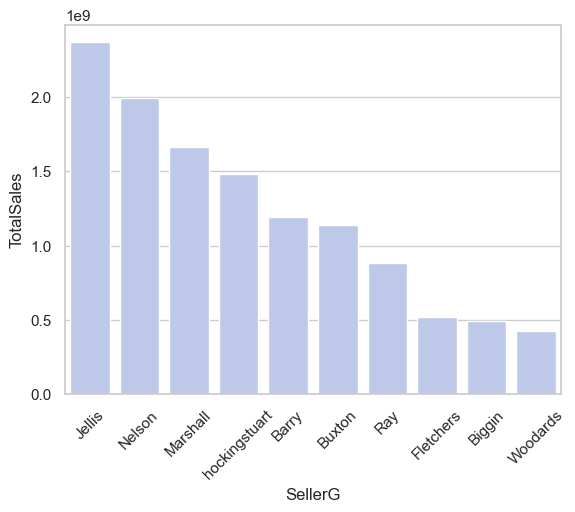

In [228]:
sns.barplot(data=sales_by_realtor.head(10), x="SellerG", y="TotalSales")
plt.xticks(rotation=45)

In [229]:
df["SellerG"] = df["SellerG"].astype("category")

In [230]:
categorial.append("SellerG")

#### 7. Date

In [231]:
# предплагаю, что дата продажи тоже мало поможет модели, даже если выделить отдельно год, так что просто исключу ее или использую при вычислении возраста здания
columns_to_drop.append("Date")

#### 8.Distance

/var/folders/sr/p3kpr51n4hs1q5w3zd7p_j0c0000gn/T/ipykernel_26624/15382175.py:2: UserWarning: The palette list has more values (37) than needed (8), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='Distance', ylabel='Price'>

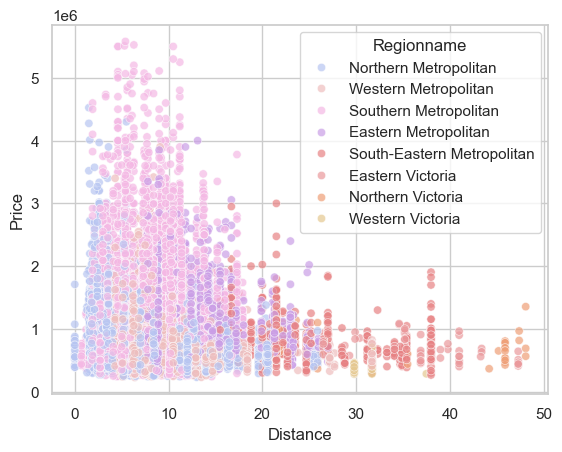

In [232]:
df["Distance"]
sns.scatterplot(
    data=train,
    x="Distance",
    y="Price",
    alpha=0.7,
    hue="Regionname",
    palette=custom_palette,
)

In [233]:
df["Distance"].describe()

count    27190.000000
mean        11.289283
std          6.789767
min          0.000000
25%          6.400000
50%         10.500000
75%         14.000000
max         48.100000
Name: Distance, dtype: float64

In [234]:
df[df["Distance"].isna()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,is_train,Street,Rooms_Group
23001,Fawkner Lot,1/3 Brian St,3,h,0.0,SP,Brad,6/01/2018,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,33262,0,Brian St,3 rooms


In [235]:
df[df["Street"] == "Brian St"]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,is_train,Street,Rooms_Group
8750,Fawkner,3 Brian St,3,h,625000.0,S,Brad,10/12/2016,12.4,3060.0,...,1960.0,Hume City Council,-37.69500,144.96760,Northern Metropolitan,5070.0,24826,1,Brian St,3 rooms
9907,Fawkner,3 Brian St,3,h,660000.0,S,Brad,8/04/2017,12.4,3060.0,...,1960.0,Hume City Council,-37.69500,144.96760,Northern Metropolitan,5070.0,20675,1,Brian St,3 rooms
23001,Fawkner Lot,1/3 Brian St,3,h,0.0,SP,Brad,6/01/2018,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,33262,0,Brian St,3 rooms
25544,Mitcham,1 Brian St,3,h,0.0,S,Philip,17/02/2018,17.2,3132.0,...,1950.0,Whitehorse City Council,-37.82505,145.18797,Eastern Metropolitan,6871.0,22739,0,Brian St,3 rooms


In [236]:
df.loc[23001, "Distance"] = 17.2

In [237]:
# тут тоже добавлю категориальную колонку
bins = [0, 6.4, 10.5, 14, 20, 30, float("inf")]
labels = [
    "0-6.4 km",
    "6.4-10.5 km",
    "10.5-14 km",
    "14-20 km",
    "20-30 km",
    "More than 30 km",
]
df["Distance_Group"] = pd.cut(df["Distance"], bins=bins, labels=labels, right=False)

In [238]:
numerical.append("Distance")
categorial.append("Distance_Group")

In [239]:
df["Distance_Group"].isna().sum()

0

#### 8. Postcode

In [240]:
# также думаю, что можно убрать эту колонку как избыточную
columns_to_drop.append("Postcode")

#### 9. Bedroom2, Bathroom, Car

In [241]:
# вероятнее всего, количество Bedroom, Bathroom, Car связано с типом

df.pivot_table(
    columns="Type",
    index="Rooms",
    aggfunc="size",
    fill_value=0,
)

Type,h,t,u
Rooms,,,
1,81,18,1072
2,2320,784,3682
3,9289,1583,1080
4,5394,467,45
5,1184,14,0
6,134,0,1
7,20,0,0
8,12,0,2
9,1,0,0


In [242]:
df.pivot_table(
    columns="Type",
    index="Bedroom2",
    aggfunc="size",
    fill_value=0,
)

Type,h,t,u
Bedroom2,,,
0.0,11,2,3
1.0,78,16,669
2.0,2058,427,2208
3.0,7949,903,561
4.0,4503,225,30
5.0,964,8,2
6.0,108,0,0
7.0,19,0,0
8.0,9,0,0


In [243]:
df.pivot_table(
    columns="Type",
    index="Bathroom",
    aggfunc="size",
    fill_value=0,
)

Type,h,t,u
Bathroom,,,
0.0,15,2,17
1.0,7274,427,2802
2.0,6846,977,635
3.0,1347,165,17
4.0,164,8,1
5.0,45,0,0
6.0,9,0,0
7.0,2,0,0
8.0,3,0,0


In [244]:
df.pivot_table(
    columns="Type",
    index="Car",
    aggfunc="size",
    fill_value=0,
)

Type,h,t,u
Car,,,
0.0,1052,20,172
1.0,4052,655,2675
2.0,7924,857,576
3.0,1168,33,31
4.0,886,11,5
5.0,111,1,0
6.0,104,0,1
7.0,18,0,1
8.0,18,0,0


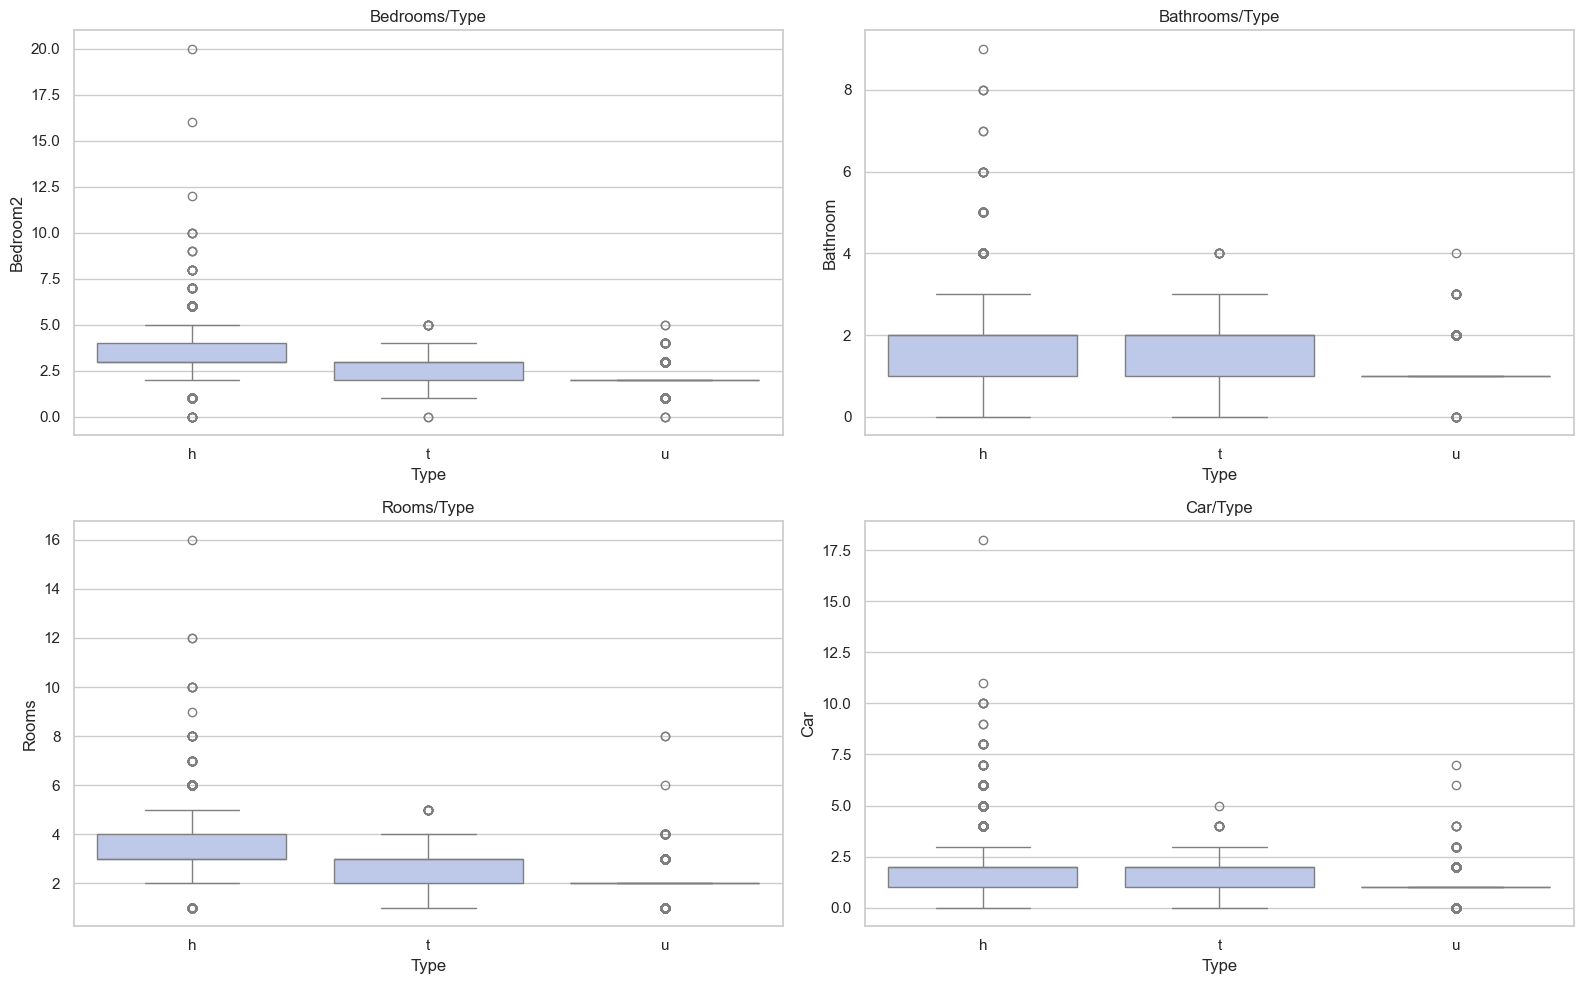

In [245]:
plt.figure(figsize=(16, 10))

# Создание подграфиков
plt.subplot(2, 2, 1)
sns.boxplot(x="Type", y="Bedroom2", data=df)
plt.title("Bedrooms/Type")

plt.subplot(2, 2, 2)
sns.boxplot(x="Type", y="Bathroom", data=df)
plt.title("Bathrooms/Type")

plt.subplot(2, 2, 3)
sns.boxplot(x="Type", y="Rooms", data=df)
plt.title("Rooms/Type")

plt.subplot(2, 2, 4)
sns.boxplot(x="Type", y="Car", data=df)
plt.title("Car/Type")

# Уплотнение графиков
plt.tight_layout()

# Отображение графиков
plt.show()

In [246]:
# мне кажется, есть смысл убрать колонку Bedroom2 потому что она визуально дублирует Rooms
columns_to_drop.append("Bedroom2")

In [247]:
# у всех типов домов в среднем 1-2 парковочных места

In [248]:
df["Car"] = df.groupby(["Rooms", "Type"])["Car"].transform(
    lambda x: x.fillna(x.median())
)
df["Bathroom"] = df.groupby(["Rooms", "Type"])["Bathroom"].transform(
    lambda x: x.fillna(x.median())
)

/Users/magewade/Desktop/kaggle/[Leopard Challenge]-regression/.venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/magewade/Desktop/kaggle/[Leopard Challenge]-regression/.venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [249]:
df[df["Car"].isna()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,is_train,Street,Rooms_Group,Distance_Group
5793,Oakleigh South,17 Windsor Av,9,h,1380000.0,S,Ray,10/09/2016,14.7,3167.0,...,Kingston City Council,NaN,NaN,South-Eastern Metropolitan,3692.0,17395,1,Windsor Av,More than 5 rooms,14-20 km


In [250]:
df[df["Bathroom"].isna()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,is_train,Street,Rooms_Group,Distance_Group
5793,Oakleigh South,17 Windsor Av,9,h,1380000.0,S,Ray,10/09/2016,14.7,3167.0,...,Kingston City Council,NaN,NaN,South-Eastern Metropolitan,3692.0,17395,1,Windsor Av,More than 5 rooms,14-20 km


In [251]:
df[df["Rooms"] == 10][["Car", "Bathroom"]]

,Car,Bathroom
2048,2.0,6.0
5846,2.0,6.0
12543,2.0,6.0
14342,2.0,3.0
20113,2.0,9.0


In [252]:
df["Car"] = df["Car"].fillna(2)

In [253]:
df["Bathroom"] = df["Bathroom"].fillna((6 + 6 + 6 + 3 + 9) / 5)

In [254]:
df.isna().sum()

Suburb                0
Address               0
Rooms                 0
Type                  0
Price                 0
Method                0
SellerG               0
Date                  0
Distance              0
Postcode              1
Bedroom2           6428
Bathroom              0
Car                   0
Landsize           9247
BuildingArea      16559
YearBuilt         15135
CouncilArea           3
Lattitude          6242
Longtitude         6242
Regionname            3
Propertycount         3
id                    0
is_train              0
Street                0
Rooms_Group           0
Distance_Group        0
dtype: int64

In [255]:
df["Bathroom"].describe()

count    27191.000000
mean         1.550697
std          0.674003
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          9.000000
Name: Bathroom, dtype: float64

In [256]:
# тоже создадим категории
bins = [0, 1, 2, 3, 4, 5, 8, float("inf")]
labels = ["0", "1", "2", "3", "4", "5", "More than 5"]

df["Bathroom_Group"] = pd.cut(df["Bathroom"], bins=bins, labels=labels, right=False)

In [257]:
df["Car"].describe()

count    27191.000000
mean         1.667096
std          0.900085
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         18.000000
Name: Car, dtype: float64

In [258]:
bins = [0, 1, 2, 3, 4, 5, 8, 10, float("inf")]
labels = ["0", "1", "2", "3", "4", "5", "6-8", "More than 8"]

df["Car_Group"] = pd.cut(df["Car"], bins=bins, labels=labels, right=False)

In [259]:
categorial.append("Car_Group")
categorial.append("Bathroom_Group")
numerical.append("Car")
numerical.append("Bathroom")

#### 10. Landsize, BuildingArea

In [260]:
# Landsize – площадь прилегающей территории

df["Landsize"].describe()

count     17944.000000
mean        593.412227
std        3761.108988
min           0.000000
25%         219.000000
50%         512.000000
75%         663.000000
max      433014.000000
Name: Landsize, dtype: float64

In [261]:
df["Landsize"].isna().sum()

9247

In [262]:
df["BuildingArea"].describe()

count    10632.000000
mean       156.689808
std        449.642312
min          0.000000
25%        100.000000
50%        133.000000
75%        181.000000
max      44515.000000
Name: BuildingArea, dtype: float64

In [263]:
df["BuildingArea"].isna().sum()

16559

<Axes: xlabel='Price', ylabel='Landsize'>

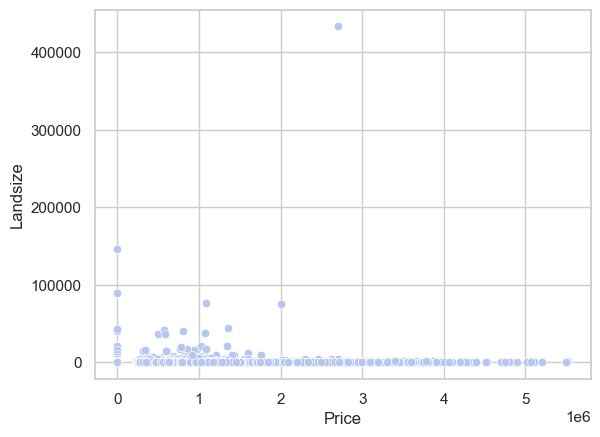

In [264]:
sns.scatterplot(data=df, x="Price", y="Landsize")

<Axes: xlabel='Price', ylabel='BuildingArea'>

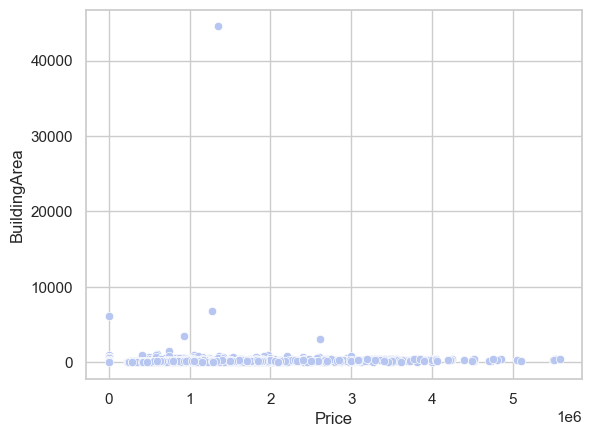

In [265]:
sns.scatterplot(data=df, x="Price", y="BuildingArea")

In [266]:
df[df["BuildingArea"] > 40000]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Longtitude,Regionname,Propertycount,id,is_train,Street,Rooms_Group,Distance_Group,Bathroom_Group,Car_Group
17617,New Gisborne,71 Hamilton Rd,5,h,1355000.0,S,Raine,23/09/2017,48.1,3438.0,...,144.58864,Northern Victoria,849.0,14451,1,Hamilton Rd,5 rooms,More than 30 km,3,5


(0.0, 300.0)

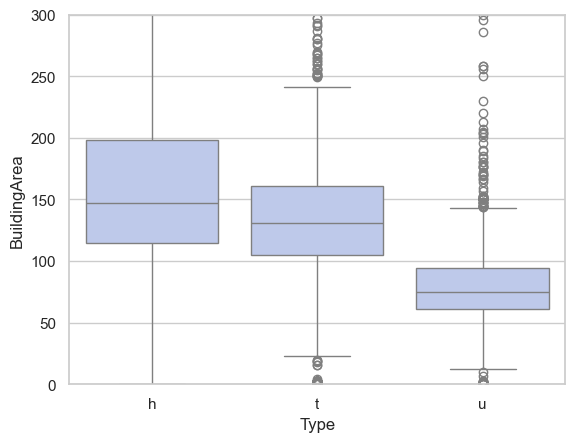

In [267]:
import matplotlib.pyplot as plt

sns.boxplot(data=df, x="Type", y="BuildingArea")
plt.ylim(0, 300)

In [268]:
df.groupby("Type")["BuildingArea"].describe()

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
h,7928.0,174.590775,512.107713,0.0,115.0,147.0,198.0,44515.0
t,919.0,148.151009,239.369239,0.0,105.0,131.0,161.0,6178.0
u,1785.0,81.579608,53.935667,0.0,61.0,75.0,94.0,1561.0


In [269]:
df["BuildingArea"] = df.groupby("Type")["BuildingArea"].transform(
    lambda x: x.fillna(df.groupby("Type")["BuildingArea"].median()[x.name])
)

In [270]:
# у house можно заметить огромный размах по площади, у всех групп минимум 0, что невозможно, и, скорее всего, является ошибкой
# думаю, есть смысл выделить группы по площади

bins = [-float("inf"), 50, 100, 150, 200, 300, 400, 500, float("inf")]
labels = [
    "0-50",
    "51-100",
    "101-150",
    "151-200",
    "201-300",
    "301-400",
    "401-500",
    "501+",
]

df["BuildingArea_Group"] = pd.cut(
    df["BuildingArea"], bins=bins, labels=labels, right=False
)

In [271]:
df["BuildingArea_Group"]

0        101-150
1         51-100
2        151-200
3        101-150
4        101-150
          ...   
27186    101-150
27187    101-150
27188    101-150
27189    101-150
27190    101-150
Name: BuildingArea_Group, Length: 27191, dtype: category
Categories (8, object): ['0-50' < '51-100' < '101-150' < '151-200' < '201-300' < '301-400' < '401-500' < '501+']

In [272]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Regionname,Propertycount,id,is_train,Street,Rooms_Group,Distance_Group,Bathroom_Group,Car_Group,BuildingArea_Group
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,Northern Metropolitan,4019.0,34302,1,Turner St,2 rooms,0-6.4 km,1,1,101-150
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,Northern Metropolitan,4019.0,33247,1,Bloomburg St,2 rooms,0-6.4 km,1,0,51-100
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,Northern Metropolitan,4019.0,31886,1,Charles St,3 rooms,0-6.4 km,2,0,151-200
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,Northern Metropolitan,4019.0,18999,1,Federation La,3 rooms,0-6.4 km,2,1,101-150
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,Northern Metropolitan,4019.0,16809,1,55a Park St,4 rooms,0-6.4 km,1,2,101-150


In [273]:
df.groupby("Type")["Landsize"].describe()

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
h,13607.0,648.195047,4235.569795,0.0,362.0,575.0,686.0,433014.0
t,1303.0,286.924021,615.866518,0.0,124.0,209.0,303.5,15900.0
u,3034.0,479.346407,1725.636159,0.0,0.0,0.0,266.0,37000.0


In [274]:
df["Landsize"].describe()

count     17944.000000
mean        593.412227
std        3761.108988
min           0.000000
25%         219.000000
50%         512.000000
75%         663.000000
max      433014.000000
Name: Landsize, dtype: float64

In [275]:
# то же с Landsize
df["Landsize"] = df.groupby("Type")["Landsize"].transform(
    lambda x: x.fillna(df.groupby("Type")["Landsize"].median()[x.name])
)


bins_landsize = [-1, 50, 100, 150, 200, 300, 400, 500, float("inf")]
labels_landsize = [
    "0-50",
    "51-100",
    "101-150",
    "151-200",
    "201-300",
    "301-400",
    "401-500",
    "501+",
]

# Применение деления на группы
df["Landsize_Group"] = pd.cut(
    df["Landsize"], bins=bins_landsize, labels=labels_landsize, right=False
)
df.pivot_table(columns="Type", index="Landsize_Group", aggfunc="size", fill_value=0)

/var/folders/sr/p3kpr51n4hs1q5w3zd7p_j0c0000gn/T/ipykernel_26624/1763771111.py:23: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df.pivot_table(columns="Type", index="Landsize_Group", aggfunc="size", fill_value=0)


Type,h,t,u
Landsize_Group,,,
0-50,180,144,4482
51-100,116,94,93
101-150,445,175,176
151-200,643,197,188
201-300,1189,1913,247
301-400,1274,205,98
401-500,1264,34,43
501+,13332,104,555


In [276]:
numerical.append("Landsize")
numerical.append("BuildingArea")
categorial.append("Landsize_Group")
categorial.append("BuildingArea_Group")

In [277]:
categorial

['Suburb',
 'Rooms_Group',
 'Type',
 'SellerG',
 'Distance_Group',
 'Car_Group',
 'Bathroom_Group',
 'Landsize_Group',
 'BuildingArea_Group']

#### 11. YearBuilt

In [278]:
df.sort_values(by="YearBuilt").head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Propertycount,id,is_train,Street,Rooms_Group,Distance_Group,Bathroom_Group,Car_Group,BuildingArea_Group,Landsize_Group
12721,Mount Waverley,5 Armstrong St,3,h,1200000.0,VB,McGrath,24/06/2017,14.2,3149.0,...,13366.0,11846,1,Armstrong St,3 rooms,14-20 km,1,4,101-150,501+
20141,Carlton North,146 Pigdon St,2,u,0.0,S,Jellis,28/10/2017,3.5,3054.0,...,3106.0,3708,0,Pigdon St,2 rooms,0-6.4 km,1,1,51-100,0-50
2710,Collingwood,2/79 Oxford St,2,u,855000.0,S,Nelson,3/09/2016,1.6,3066.0,...,4553.0,18501,1,Oxford St,2 rooms,0-6.4 km,1,1,101-150,501+
6909,Richmond,22a Stanley St,3,h,1600000.0,S,Biggin,24/09/2016,2.6,3121.0,...,14949.0,18112,1,22a Stanley St,3 rooms,0-6.4 km,2,2,101-150,51-100
3261,Fitzroy,11 Henry St,2,h,677000.0,S,Chambers,27/11/2016,1.6,3065.0,...,5825.0,15159,1,Henry St,2 rooms,0-6.4 km,1,0,101-150,51-100


In [279]:
df["YearBuilt"].describe()

count    12056.000000
mean      1966.654778
std         36.725334
min       1196.000000
25%       1950.000000
50%       1970.000000
75%       2000.000000
max       2019.000000
Name: YearBuilt, dtype: float64

In [280]:
# минимальный год выглядит подозрительно, посмотрела на гугл картах по адресу, по виду нормальный кирпичный дом, не крепость 12 века, так что скорее всего ошибка
import numpy as np

df["YearBuilt"] = df["YearBuilt"].replace(1196, np.nan)

In [281]:
df.sort_values(by="YearBuilt").head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Propertycount,id,is_train,Street,Rooms_Group,Distance_Group,Bathroom_Group,Car_Group,BuildingArea_Group,Landsize_Group
20141,Carlton North,146 Pigdon St,2,u,0.0,S,Jellis,28/10/2017,3.5,3054.0,...,3106.0,3708,0,Pigdon St,2 rooms,0-6.4 km,1,1,51-100,0-50
2710,Collingwood,2/79 Oxford St,2,u,855000.0,S,Nelson,3/09/2016,1.6,3066.0,...,4553.0,18501,1,Oxford St,2 rooms,0-6.4 km,1,1,101-150,501+
7464,St Kilda,51/167 Fitzroy St,3,u,1600000.0,PI,Kay,25/02/2017,6.1,3182.0,...,13240.0,23749,1,Fitzroy St,3 rooms,0-6.4 km,2,2,0-50,0-50
6167,Prahran,602/220 Commercial Rd,2,u,841000.0,S,hockingstuart,18/03/2017,4.5,3181.0,...,7717.0,21987,1,Commercial Rd,2 rooms,0-6.4 km,2,1,101-150,0-50
6909,Richmond,22a Stanley St,3,h,1600000.0,S,Biggin,24/09/2016,2.6,3121.0,...,14949.0,18112,1,22a Stanley St,3 rooms,0-6.4 km,2,2,101-150,51-100


In [282]:
# будет неплохой идеей сделать колонку с возрастом дома на момент продажи, так как у нас есть дата продажи и дата постройки
# но сначала надо заполнить пропуски, будем заполнять средним по suburb
mean_year_built = df.groupby("Suburb")["YearBuilt"].mean()

# Заполняем пропуски в YearBuilt средним значением по соответствующему району
df["YearBuilt"] = df.apply(
    lambda row: (
        mean_year_built[row["Suburb"]]
        if pd.isna(row["YearBuilt"])
        else row["YearBuilt"]
    ),
    axis=1,
)

In [283]:
df["YearBuilt"].isna().sum()

103

In [284]:
# то, что осталось, заполним по CouncilArea
mean_year_built = df.groupby("CouncilArea")["YearBuilt"].transform(lambda x: x.mean())

# Заполняем пропуски в YearBuilt средним значением по соответствующему району
df["YearBuilt"] = df["YearBuilt"].fillna(mean_year_built)

In [285]:
df["YearBuilt"].isna().sum()

1

In [286]:
df[df["YearBuilt"].isna()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Propertycount,id,is_train,Street,Rooms_Group,Distance_Group,Bathroom_Group,Car_Group,BuildingArea_Group,Landsize_Group
23001,Fawkner Lot,1/3 Brian St,3,h,0.0,SP,Brad,6/01/2018,17.2,NaN,...,NaN,33262,0,Brian St,3 rooms,14-20 km,1,2,101-150,501+


In [287]:
df[df["Street"] == "Brian St"]["YearBuilt"]

8750     1960.0
9907     1960.0
23001       NaN
25544    1950.0
Name: YearBuilt, dtype: float64

In [288]:
df.loc[23001, "YearBuilt"] = 1960

In [289]:
# Преобразуем строки с датами в объекты типа datetime
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")

# Извлекаем год из даты
df["Year"] = df["Date"].dt.year

In [290]:
# так, теперь посчитаем возраст дома
# # Вычисляем возраст и добавляем новый столбец
df["Age"] = df["Year"] - df["YearBuilt"]

In [291]:
df["Age"].isna().sum()

0

In [292]:
# # Определите диапазоны и метки, добавляя диапазон для NaN
# bins_yearbuilt = [
#     -float("inf"),
#     1860,
#     1875,
#     1895,
#     1920,
#     1944,
#     1960,
#     1970,
#     1990,
#     2000,
#     float("inf"),
# ]
# labels_yearbuilt = [
#     "NaN",
#     "1860-1874",
#     "1875-1894",
#     "1895-1919",
#     "1920-1943",
#     "1944-1959",
#     "1960-1969",
#     "1970-1989",
#     "1990-1999",
#     "2000+",
# ]

# df["YearBuilt_Group"] = pd.cut(
#     df["YearBuilt"].fillna(-1),
#     bins=bins_yearbuilt,
#     labels=labels_yearbuilt,
#     right=False,
# ).astype("object")

In [293]:
# df["YearBuilt_Group"].isna().sum()

In [294]:
columns_to_drop.append("YearBuilt")
columns_to_drop.append("Year")
numerical.append("Age")

#### 12. CouncilArea, Regionname

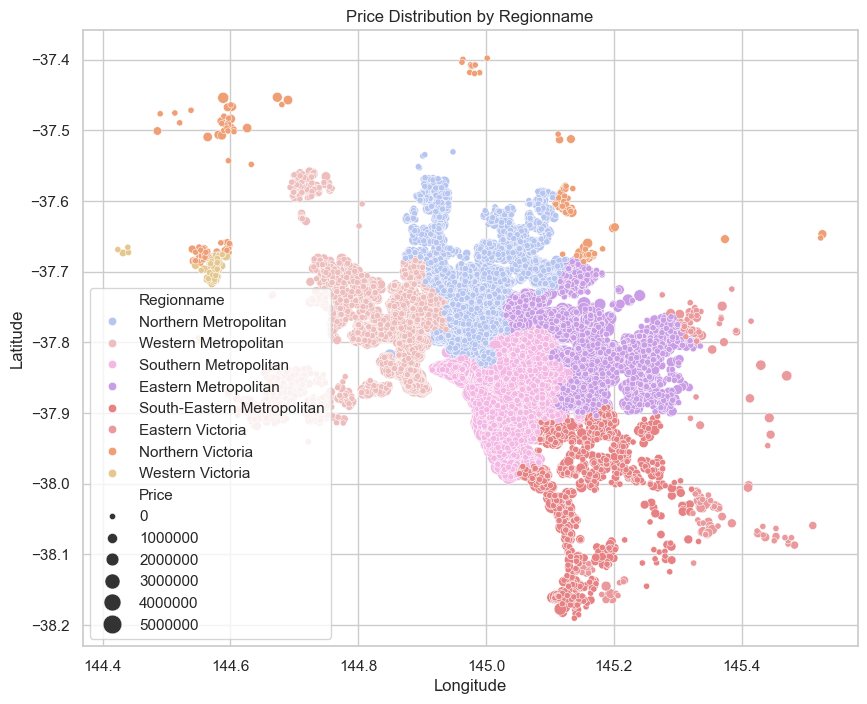

In [295]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

sns.scatterplot(
    x="Longtitude",
    y="Lattitude",
    size="Price",
    sizes=(20, 200),
    hue="Regionname",
    data=df,
)

plt.title("Price Distribution by Regionname")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Показываем график
plt.show()

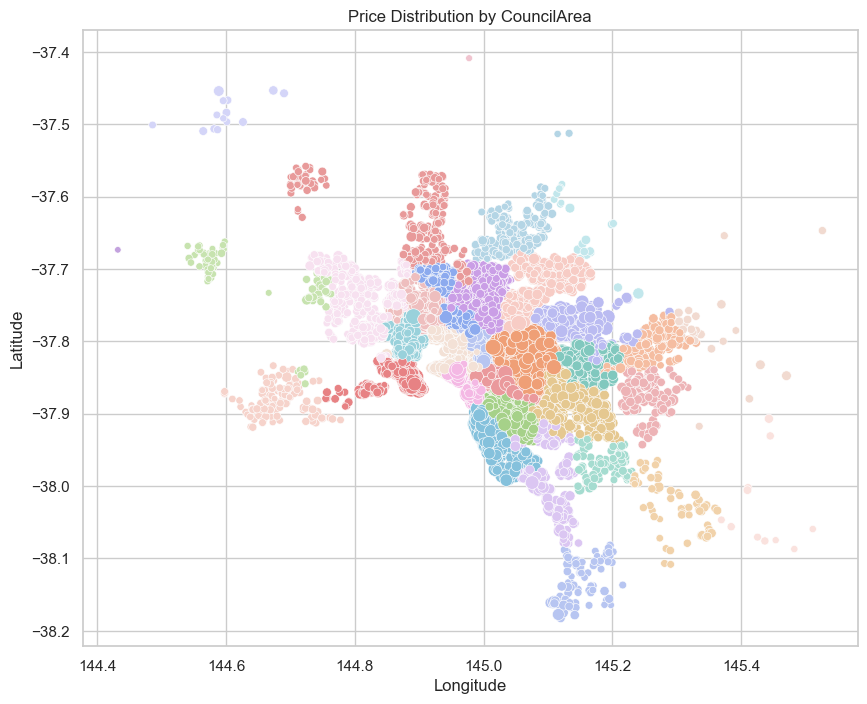

In [296]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

sns.scatterplot(
    x="Longtitude",
    y="Lattitude",
    size="Price",
    sizes=(20, 200),
    hue="CouncilArea",
    data=train,
    legend=False,
)

plt.title("Price Distribution by CouncilArea")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Показываем график
plt.show()

In [297]:
# думаю можно оставить обе колонки, хоть они и выглядят взаимоисключающими, но для catboost это может быть не проблема

In [298]:
categorial.append("CouncilArea")
categorial.append("Regionname")

#### 13. Propertycount

In [299]:
df["Propertycount"].describe()

count    27188.000000
mean      7567.178277
std       4491.421957
min         83.000000
25%       4294.000000
50%       6567.000000
75%      10412.000000
max      21650.000000
Name: Propertycount, dtype: float64

In [300]:
df["Propertycount"].isna().sum()

3

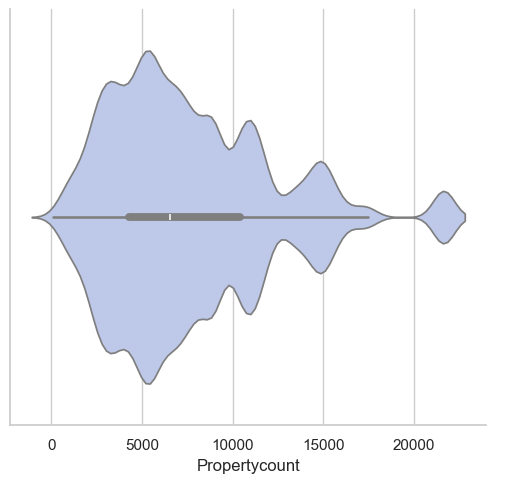

In [301]:
sns.catplot(data=df, x="Propertycount", kind="violin")

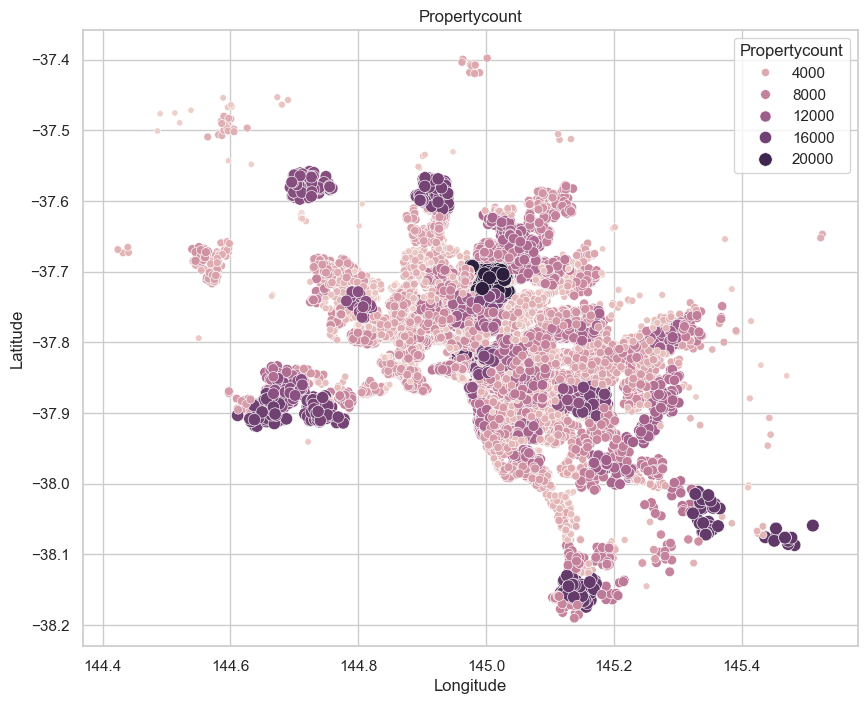

In [302]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x="Longtitude",
    y="Lattitude",
    size="Propertycount",
    sizes=(20, 100),
    hue="Propertycount",
    data=df,
    legend=True,
)

plt.title("Propertycount")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Показываем график
plt.show()

In [303]:
df[df["Propertycount"].isna()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,is_train,Street,Rooms_Group,Distance_Group,Bathroom_Group,Car_Group,BuildingArea_Group,Landsize_Group,Year,Age
14406,Footscray,2/16 Stafford St,2,u,710000.0,S,Jas,2017-07-15,5.1,3011.0,...,1,Stafford St,2 rooms,0-6.4 km,1,1,51-100,0-50,2017,63.906780
21007,Camberwell,2/3 Kingsley St,2,h,0.0,VB,Jellis,2017-11-11,7.7,3124.0,...,0,Kingsley St,2 rooms,6.4-10.5 km,1,1,101-150,501+,2017,62.228814
23001,Fawkner Lot,1/3 Brian St,3,h,0.0,SP,Brad,2018-01-06,17.2,NaN,...,0,Brian St,3 rooms,14-20 km,1,2,101-150,501+,2018,58.000000


In [304]:
df.loc[14406, "Propertycount"] = df[df["Suburb"] == "Footscray"]["Propertycount"].mean()
df.loc[21007, "Propertycount"] = df[df["Suburb"] == "Camberwell"][
    "Propertycount"
].mean()
df.loc[23001, "Propertycount"] = df[df["Suburb"] == "Fawkner Lot"][
    "Propertycount"
].mean()

In [305]:
df[df["Propertycount"].isna()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,is_train,Street,Rooms_Group,Distance_Group,Bathroom_Group,Car_Group,BuildingArea_Group,Landsize_Group,Year,Age
23001,Fawkner Lot,1/3 Brian St,3,h,0.0,SP,Brad,2018-01-06,17.2,NaN,...,0,Brian St,3 rooms,14-20 km,1,2,101-150,501+,2018,58.0


In [306]:
df.loc[23001, "Propertycount"] = df[df["Street"] == "Brian St"]["Propertycount"].mean()

In [307]:
numerical.append("Propertycount")

## 3. Preprocessing and final fixes
___

In [308]:
df[categorial]

,Suburb,Rooms_Group,Type,SellerG,Distance_Group,Car_Group,Bathroom_Group,Landsize_Group,BuildingArea_Group,CouncilArea,Regionname
0,Abbotsford,2 rooms,h,Biggin,0-6.4 km,1,1,201-300,101-150,Yarra City Council,Northern Metropolitan
1,Abbotsford,2 rooms,h,Biggin,0-6.4 km,0,1,151-200,51-100,Yarra City Council,Northern Metropolitan
2,Abbotsford,3 rooms,h,Biggin,0-6.4 km,0,2,101-150,151-200,Yarra City Council,Northern Metropolitan
3,Abbotsford,3 rooms,h,Biggin,0-6.4 km,1,2,51-100,101-150,Yarra City Council,Northern Metropolitan
4,Abbotsford,4 rooms,h,Nelson,0-6.4 km,2,1,101-150,101-150,Yarra City Council,Northern Metropolitan
...,...,...,...,...,...,...,...,...,...,...,...
27186,Yarraville,4 rooms,h,Jas,0-6.4 km,3,1,501+,101-150,Maribyrnong City Council,Western Metropolitan
27187,Yarraville,2 rooms,h,Sweeney,0-6.4 km,1,2,51-100,101-150,Maribyrnong City Council,Western Metropolitan
27188,Yarraville,2 rooms,t,Jas,0-6.4 km,2,1,201-300,101-150,Maribyrnong City Council,Western Metropolitan
27189,Yarraville,3 rooms,h,hockingstuart,0-6.4 km,2,1,501+,101-150,Maribyrnong City Council,Western Metropolitan


In [309]:
df[numerical]

,Rooms,Distance,Car,Bathroom,Landsize,BuildingArea,Age,Propertycount
0,2,2.5,1.0,1.0,202.0,147.0,72.784314,4019.0
1,2,2.5,0.0,1.0,156.0,79.0,116.000000,4019.0
2,3,2.5,0.0,2.0,134.0,150.0,117.000000,4019.0
3,3,2.5,1.0,2.0,94.0,147.0,73.784314,4019.0
4,4,2.5,2.0,1.0,120.0,142.0,2.000000,4019.0
...,...,...,...,...,...,...,...,...
27186,4,6.3,3.0,1.0,593.0,147.0,67.283688,6543.0
27187,2,6.3,1.0,2.0,98.0,104.0,0.000000,6543.0
27188,2,6.3,2.0,1.0,220.0,120.0,18.000000,6543.0
27189,3,6.3,2.0,1.0,575.0,147.0,67.283688,6543.0


In [310]:
X = categorial + numerical

In [311]:
X

['Suburb',
 'Rooms_Group',
 'Type',
 'SellerG',
 'Distance_Group',
 'Car_Group',
 'Bathroom_Group',
 'Landsize_Group',
 'BuildingArea_Group',
 'CouncilArea',
 'Regionname',
 'Rooms',
 'Distance',
 'Car',
 'Bathroom',
 'Landsize',
 'BuildingArea',
 'Age',
 'Propertycount']

In [312]:
df[X]

,Suburb,Rooms_Group,Type,SellerG,Distance_Group,Car_Group,Bathroom_Group,Landsize_Group,BuildingArea_Group,CouncilArea,Regionname,Rooms,Distance,Car,Bathroom,Landsize,BuildingArea,Age,Propertycount
0,Abbotsford,2 rooms,h,Biggin,0-6.4 km,1,1,201-300,101-150,Yarra City Council,Northern Metropolitan,2,2.5,1.0,1.0,202.0,147.0,72.784314,4019.0
1,Abbotsford,2 rooms,h,Biggin,0-6.4 km,0,1,151-200,51-100,Yarra City Council,Northern Metropolitan,2,2.5,0.0,1.0,156.0,79.0,116.000000,4019.0
2,Abbotsford,3 rooms,h,Biggin,0-6.4 km,0,2,101-150,151-200,Yarra City Council,Northern Metropolitan,3,2.5,0.0,2.0,134.0,150.0,117.000000,4019.0
3,Abbotsford,3 rooms,h,Biggin,0-6.4 km,1,2,51-100,101-150,Yarra City Council,Northern Metropolitan,3,2.5,1.0,2.0,94.0,147.0,73.784314,4019.0
4,Abbotsford,4 rooms,h,Nelson,0-6.4 km,2,1,101-150,101-150,Yarra City Council,Northern Metropolitan,4,2.5,2.0,1.0,120.0,142.0,2.000000,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27186,Yarraville,4 rooms,h,Jas,0-6.4 km,3,1,501+,101-150,Maribyrnong City Council,Western Metropolitan,4,6.3,3.0,1.0,593.0,147.0,67.283688,6543.0
27187,Yarraville,2 rooms,h,Sweeney,0-6.4 km,1,2,51-100,101-150,Maribyrnong City Council,Western Metropolitan,2,6.3,1.0,2.0,98.0,104.0,0.000000,6543.0
27188,Yarraville,2 rooms,t,Jas,0-6.4 km,2,1,201-300,101-150,Maribyrnong City Council,Western Metropolitan,2,6.3,2.0,1.0,220.0,120.0,18.000000,6543.0
27189,Yarraville,3 rooms,h,hockingstuart,0-6.4 km,2,1,501+,101-150,Maribyrnong City Council,Western Metropolitan,3,6.3,2.0,1.0,575.0,147.0,67.283688,6543.0


In [313]:
df[X].isna().sum()

Suburb                0
Rooms_Group           0
Type                  0
SellerG               0
Distance_Group        0
Car_Group             0
Bathroom_Group        0
Landsize_Group        0
BuildingArea_Group    0
CouncilArea           3
Regionname            3
Rooms                 0
Distance              0
Car                   0
Bathroom              0
Landsize              0
BuildingArea          0
Age                   0
Propertycount         0
dtype: int64

In [314]:
df[df["CouncilArea"].isna()][X]

,Suburb,Rooms_Group,Type,SellerG,Distance_Group,Car_Group,Bathroom_Group,Landsize_Group,BuildingArea_Group,CouncilArea,Regionname,Rooms,Distance,Car,Bathroom,Landsize,BuildingArea,Age,Propertycount
14406,Footscray,2 rooms,u,Jas,0-6.4 km,1,1,0-50,51-100,NaN,NaN,2,5.1,1.0,1.0,0.0,75.0,63.906780,7570.000000
21007,Camberwell,2 rooms,h,Jellis,6.4-10.5 km,1,1,501+,101-150,NaN,NaN,2,7.7,1.0,1.0,575.0,147.0,62.228814,8920.000000
23001,Fawkner Lot,3 rooms,h,Brad,14-20 km,2,1,501+,101-150,NaN,NaN,3,17.2,2.0,1.0,575.0,147.0,58.000000,5670.333333


In [315]:
df[df["Suburb"] == "Footscray"]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,is_train,Street,Rooms_Group,Distance_Group,Bathroom_Group,Car_Group,BuildingArea_Group,Landsize_Group,Year,Age
3368,Footscray,4/33 Ballarat Rd,3,t,585000.0,S,Nelson,2016-09-03,6.4,3011.0,...,1,Ballarat Rd,3 rooms,6.4-10.5 km,1,1,101-150,201-300,2016,62.90678
3369,Footscray,4 Adelaide St,4,h,1225000.0,SP,Nelson,2016-12-03,6.4,3011.0,...,1,Adelaide St,4 rooms,6.4-10.5 km,2,1,101-150,301-400,2016,101.00000
3370,Footscray,11/44 Everard St,2,u,431000.0,SP,Jas,2016-12-03,6.4,3011.0,...,1,Everard St,2 rooms,6.4-10.5 km,1,1,51-100,0-50,2016,62.90678
3371,Footscray,9 Lynch St,3,h,1003000.0,S,Naison,2016-12-03,6.4,3011.0,...,1,Lynch St,3 rooms,6.4-10.5 km,1,1,51-100,201-300,2016,116.00000
3372,Footscray,25 Southampton St,3,h,840000.0,S,Sweeney,2016-12-03,6.4,3011.0,...,1,Southampton St,3 rooms,6.4-10.5 km,1,0,51-100,151-200,2016,116.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26732,Footscray,105 Eleanor St,3,h,0.0,S,Jas,2018-02-24,5.1,3011.0,...,0,Eleanor St,3 rooms,0-6.4 km,1,0,101-150,201-300,2018,118.00000
26733,Footscray,4/5 Gordon St,2,u,0.0,SP,Woodards,2018-02-24,5.1,3011.0,...,0,Gordon St,2 rooms,0-6.4 km,1,1,51-100,0-50,2018,64.90678
26734,Footscray,11/49 Hyde St,2,u,0.0,S,McGrath,2018-02-24,5.1,3011.0,...,0,Hyde St,2 rooms,0-6.4 km,1,1,51-100,0-50,2018,64.90678
26735,Footscray,2/1 Leander St,2,t,0.0,PI,Jas,2018-02-24,5.1,3011.0,...,0,Leander St,2 rooms,0-6.4 km,1,1,101-150,201-300,2018,64.90678


In [316]:
df.loc[14406, "CouncilArea"] = "Maribyrnong City Council"
df.loc[14406, "Regionname"] = "Western Metropolitan"
df.loc[14406, "Propertycount"] = 7570

In [317]:
df[X].isna().sum()

Suburb                0
Rooms_Group           0
Type                  0
SellerG               0
Distance_Group        0
Car_Group             0
Bathroom_Group        0
Landsize_Group        0
BuildingArea_Group    0
CouncilArea           2
Regionname            2
Rooms                 0
Distance              0
Car                   0
Bathroom              0
Landsize              0
BuildingArea          0
Age                   0
Propertycount         0
dtype: int64

In [318]:
df[df["CouncilArea"].isna()][X]

,Suburb,Rooms_Group,Type,SellerG,Distance_Group,Car_Group,Bathroom_Group,Landsize_Group,BuildingArea_Group,CouncilArea,Regionname,Rooms,Distance,Car,Bathroom,Landsize,BuildingArea,Age,Propertycount
21007,Camberwell,2 rooms,h,Jellis,6.4-10.5 km,1,1,501+,101-150,NaN,NaN,2,7.7,1.0,1.0,575.0,147.0,62.228814,8920.000000
23001,Fawkner Lot,3 rooms,h,Brad,14-20 km,2,1,501+,101-150,NaN,NaN,3,17.2,2.0,1.0,575.0,147.0,58.000000,5670.333333


In [319]:
df[df["CouncilArea"].isna()][["Suburb", "CouncilArea", "Street"]]

,Suburb,CouncilArea,Street
21007,Camberwell,NaN,Kingsley St
23001,Fawkner Lot,NaN,Brian St


In [320]:
df[df["Suburb"] == "Camberwell"][
    ["CouncilArea", "Regionname", "Distance", "Propertycount"]
]

,CouncilArea,Regionname,Distance,Propertycount
2052,Boroondara City Council,Southern Metropolitan,7.8,8920.0
2053,Boroondara City Council,Southern Metropolitan,7.8,8920.0
2054,Boroondara City Council,Southern Metropolitan,7.8,8920.0
2055,Boroondara City Council,Southern Metropolitan,7.8,8920.0
2056,Boroondara City Council,Southern Metropolitan,7.8,8920.0
...,...,...,...,...
26591,Boroondara City Council,Southern Metropolitan,7.7,8920.0
26592,Boroondara City Council,Southern Metropolitan,7.7,8920.0
26593,Boroondara City Council,Southern Metropolitan,7.7,8920.0
26594,Boroondara City Council,Southern Metropolitan,7.7,8920.0


In [321]:
df.loc[21007, "CouncilArea"] = "Boroondara City Council"
df.loc[21007, "Regionname"] = "Southern Metropolitan"
df.loc[21007, "Propertycount"] = 8920.0

In [322]:
df[df["Street"] == "Brian St"][
    ["CouncilArea", "Regionname", "Distance", "Propertycount"]
]

,CouncilArea,Regionname,Distance,Propertycount
8750,Hume City Council,Northern Metropolitan,12.4,5070.000000
9907,Hume City Council,Northern Metropolitan,12.4,5070.000000
23001,NaN,NaN,17.2,5670.333333
25544,Whitehorse City Council,Eastern Metropolitan,17.2,6871.000000


In [323]:
df.loc[23001, "CouncilArea"] = "Whitehorse City Council"
df.loc[23001, "Regionname"] = "Eastern Metropolitan"
df.loc[23001, "Propertycount"] = 6871.0

In [324]:
df[X].isna().sum()

Suburb                0
Rooms_Group           0
Type                  0
SellerG               0
Distance_Group        0
Car_Group             0
Bathroom_Group        0
Landsize_Group        0
BuildingArea_Group    0
CouncilArea           0
Regionname            0
Rooms                 0
Distance              0
Car                   0
Bathroom              0
Landsize              0
BuildingArea          0
Age                   0
Propertycount         0
dtype: int64

In [325]:
df[["Bathroom", "Car"]] = df[["Bathroom", "Car"]].astype("int")
df[["Bathroom", "Car"]] = df[["Bathroom", "Car"]].astype("int")

In [326]:
y = ["Price"]

In [327]:
X

['Suburb',
 'Rooms_Group',
 'Type',
 'SellerG',
 'Distance_Group',
 'Car_Group',
 'Bathroom_Group',
 'Landsize_Group',
 'BuildingArea_Group',
 'CouncilArea',
 'Regionname',
 'Rooms',
 'Distance',
 'Car',
 'Bathroom',
 'Landsize',
 'BuildingArea',
 'Age',
 'Propertycount']

In [328]:
categorial

['Suburb',
 'Rooms_Group',
 'Type',
 'SellerG',
 'Distance_Group',
 'Car_Group',
 'Bathroom_Group',
 'Landsize_Group',
 'BuildingArea_Group',
 'CouncilArea',
 'Regionname']

In [329]:
numerical

['Rooms',
 'Distance',
 'Car',
 'Bathroom',
 'Landsize',
 'BuildingArea',
 'Age',
 'Propertycount']

In [330]:
y

['Price']

In [331]:
# поделим как было, чтобы посмотреть на корреляции
train = df[df["is_train"] == 1].drop(columns=["is_train"])
test = df[df["is_train"] == 0].drop(columns=["is_train", "Price"])

<Axes: >

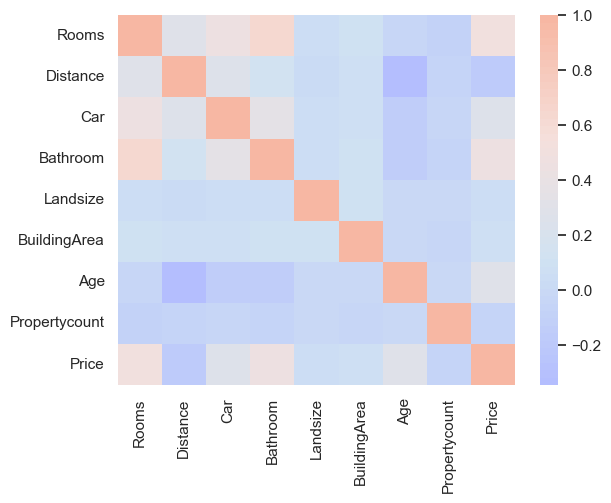

In [332]:
corr = train[numerical + y].corr()
sns.heatmap(corr, cmap=cmap)

In [333]:
columns_for_corr = X + y

In [334]:
train[columns_for_corr].isna().sum()

Suburb                0
Rooms_Group           0
Type                  0
SellerG               0
Distance_Group        0
Car_Group             0
Bathroom_Group        0
Landsize_Group        0
BuildingArea_Group    0
CouncilArea           0
Regionname            0
Rooms                 0
Distance              0
Car                   0
Bathroom              0
Landsize              0
BuildingArea          0
Age                   0
Propertycount         0
Price                 0
dtype: int64

In [335]:
for col in categorial:
    df[col] = df[col].astype("category")

In [336]:
columns_for_corr = X + y

In [337]:
phik_overview = train[columns_for_corr].phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['Rooms', 'Distance', 'Car', 'Bathroom', 'Landsize', 'BuildingArea', 'Age', 'Propertycount', 'Price']


,Suburb,Rooms_Group,Type,SellerG,Distance_Group,Car_Group,Bathroom_Group,Landsize_Group,BuildingArea_Group,CouncilArea,Regionname,Rooms,Distance,Car,Bathroom,Landsize,BuildingArea,Age,Propertycount,Price
Suburb,1.00,0.52,0.58,0.98,1.00,0.48,0.36,0.58,0.46,1.00,1.00,0.49,1.00,0.44,0.38,0.61,0.65,0.79,1.00,0.61
Rooms_Group,0.52,1.00,0.77,0.34,0.42,0.44,0.52,0.47,0.57,0.41,0.20,0.96,0.30,0.46,0.60,0.00,0.05,0.11,0.18,0.44
Type,0.58,0.77,1.00,0.42,0.44,0.48,0.33,0.75,0.70,0.48,0.23,0.59,0.31,0.47,0.47,0.00,0.00,0.30,0.24,0.50
SellerG,0.98,0.34,0.42,1.00,0.77,0.30,0.40,0.36,0.36,0.94,0.85,0.63,0.81,0.24,0.37,0.00,0.00,0.40,0.65,0.48
Distance_Group,1.00,0.42,0.44,0.77,1.00,0.28,0.13,0.33,0.23,0.91,0.60,0.29,0.95,0.28,0.16,0.11,0.09,0.42,0.46,0.19
Car_Group,0.48,0.44,0.48,0.30,0.28,1.00,0.33,0.54,0.50,0.36,0.22,0.43,0.29,0.98,0.33,0.05,0.09,0.24,0.12,0.29
Bathroom_Group,0.36,0.52,0.33,0.40,0.13,0.33,1.00,0.20,0.43,0.26,0.14,0.59,0.14,0.37,1.00,0.02,0.02,0.19,0.11,0.39
Landsize_Group,0.58,0.47,0.75,0.36,0.33,0.54,0.20,1.00,0.64,0.45,0.31,0.44,0.34,0.38,0.21,0.00,0.00,0.28,0.20,0.31
BuildingArea_Group,0.46,0.57,0.70,0.36,0.23,0.50,0.43,0.64,1.00,0.33,0.23,0.53,0.23,0.36,0.43,0.07,0.19,0.24,0.16,0.43
CouncilArea,1.00,0.41,0.48,0.94,0.91,0.36,0.26,0.45,0.33,1.00,0.97,0.37,0.93,0.33,0.26,0.25,0.34,0.48,0.79,0.51


<Axes: >

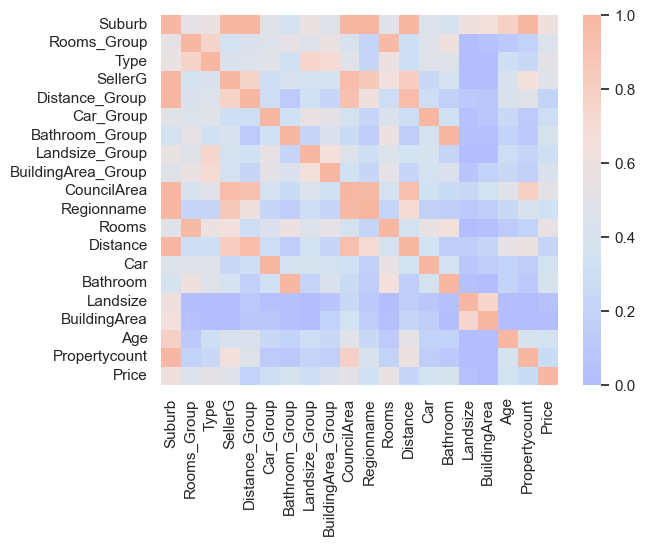

In [338]:
sns.heatmap(phik_overview.round(2), cmap=cmap)

array([[<Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Distance'}>,
        <Axes: title={'center': 'Car'}>],
       [<Axes: title={'center': 'Bathroom'}>,
        <Axes: title={'center': 'Landsize'}>,
        <Axes: title={'center': 'BuildingArea'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Propertycount'}>, <Axes: >]],
      dtype=object)

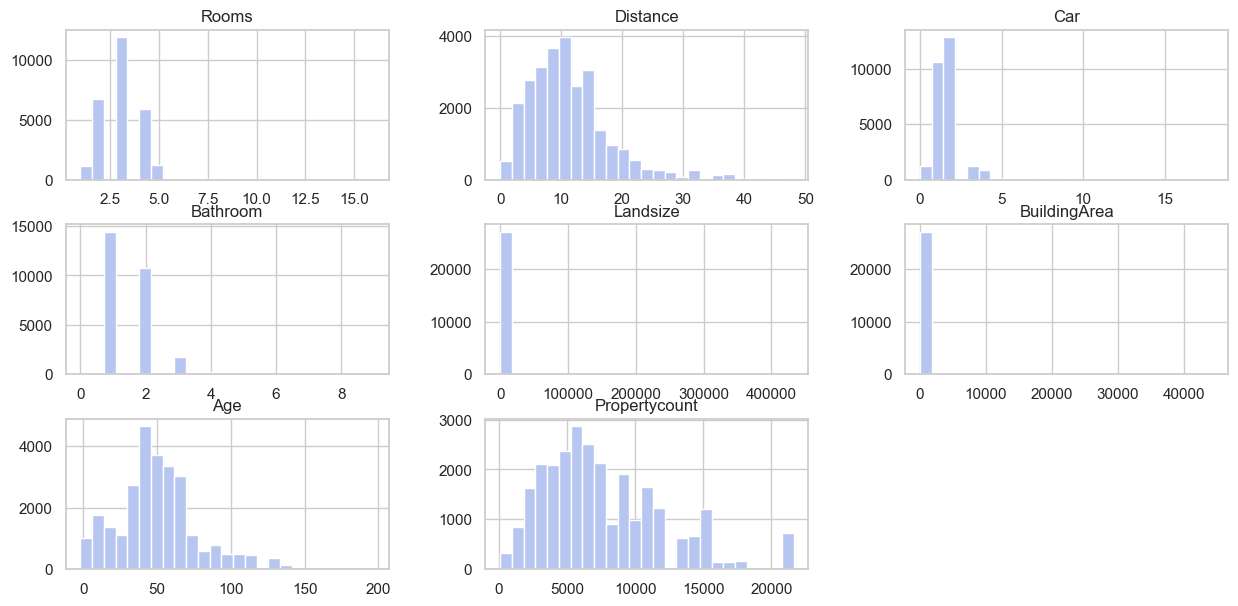

In [339]:
df[numerical].hist(bins=25, figsize=(15, 7))

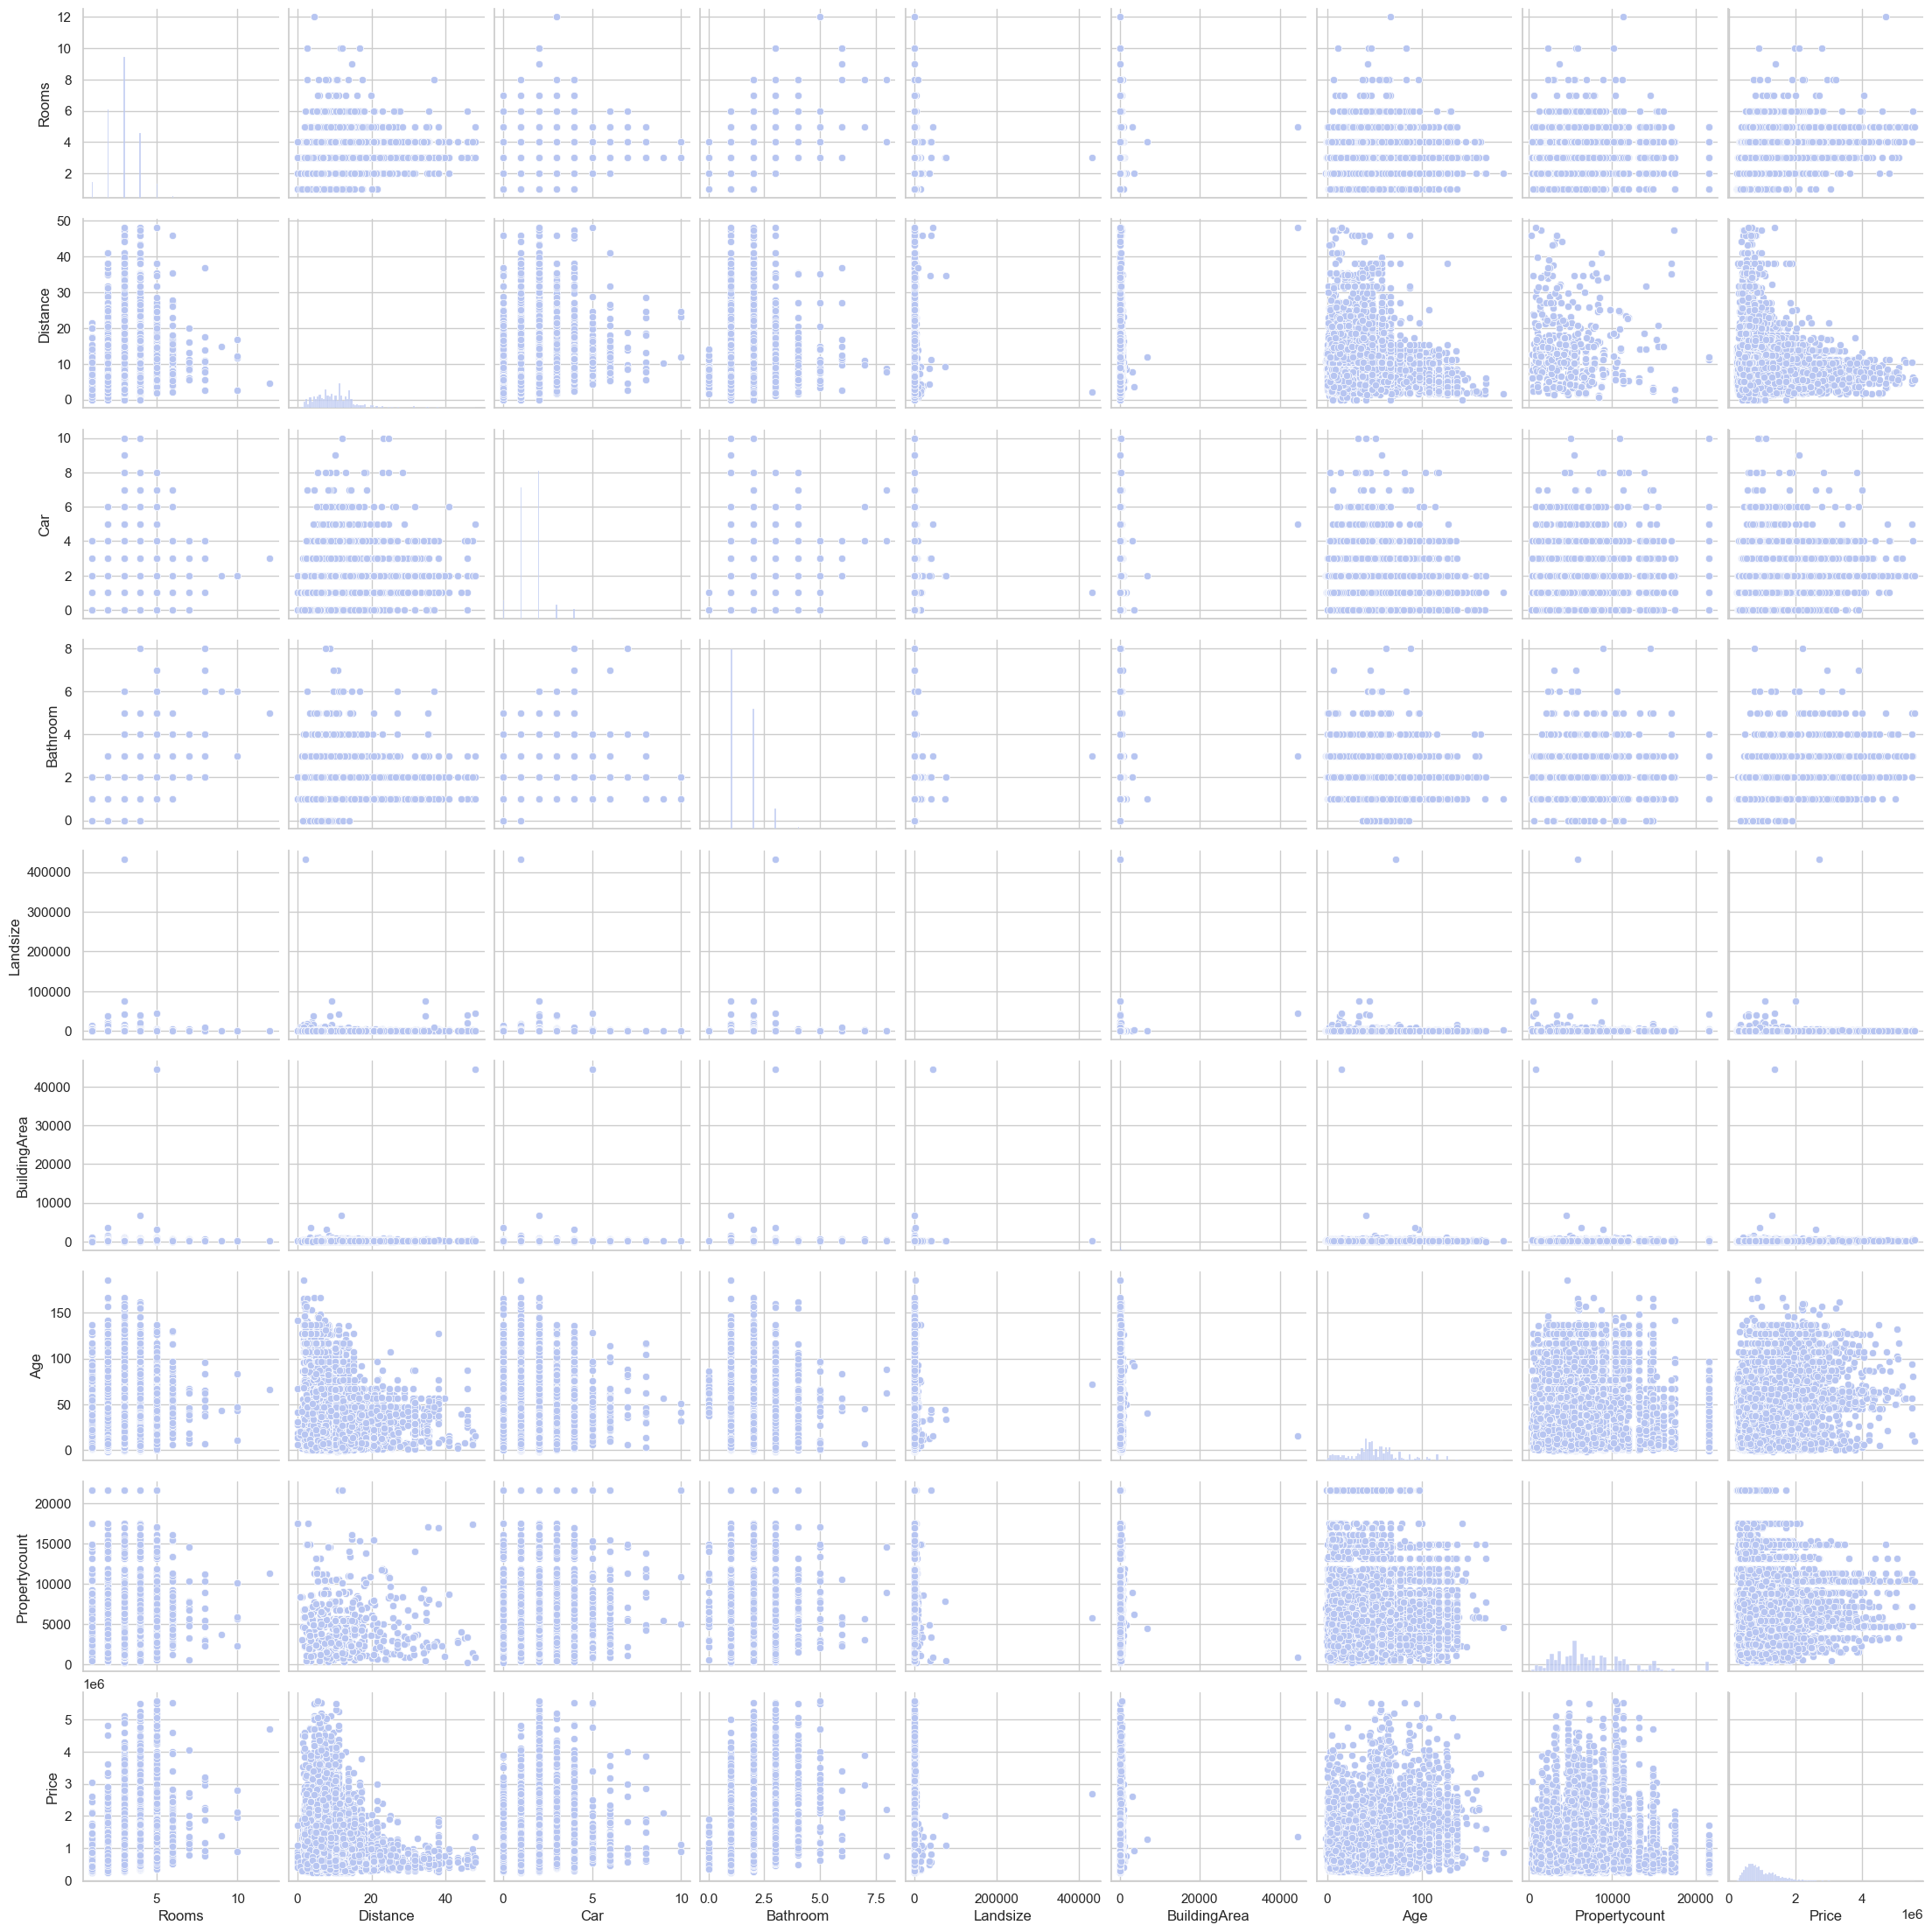

In [340]:
sns.pairplot(data=train[columns_for_corr])

In [341]:
df[X]

,Suburb,Rooms_Group,Type,SellerG,Distance_Group,Car_Group,Bathroom_Group,Landsize_Group,BuildingArea_Group,CouncilArea,Regionname,Rooms,Distance,Car,Bathroom,Landsize,BuildingArea,Age,Propertycount
0,Abbotsford,2 rooms,h,Biggin,0-6.4 km,1,1,201-300,101-150,Yarra City Council,Northern Metropolitan,2,2.5,1,1,202.0,147.0,72.784314,4019.0
1,Abbotsford,2 rooms,h,Biggin,0-6.4 km,0,1,151-200,51-100,Yarra City Council,Northern Metropolitan,2,2.5,0,1,156.0,79.0,116.000000,4019.0
2,Abbotsford,3 rooms,h,Biggin,0-6.4 km,0,2,101-150,151-200,Yarra City Council,Northern Metropolitan,3,2.5,0,2,134.0,150.0,117.000000,4019.0
3,Abbotsford,3 rooms,h,Biggin,0-6.4 km,1,2,51-100,101-150,Yarra City Council,Northern Metropolitan,3,2.5,1,2,94.0,147.0,73.784314,4019.0
4,Abbotsford,4 rooms,h,Nelson,0-6.4 km,2,1,101-150,101-150,Yarra City Council,Northern Metropolitan,4,2.5,2,1,120.0,142.0,2.000000,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27186,Yarraville,4 rooms,h,Jas,0-6.4 km,3,1,501+,101-150,Maribyrnong City Council,Western Metropolitan,4,6.3,3,1,593.0,147.0,67.283688,6543.0
27187,Yarraville,2 rooms,h,Sweeney,0-6.4 km,1,2,51-100,101-150,Maribyrnong City Council,Western Metropolitan,2,6.3,1,2,98.0,104.0,0.000000,6543.0
27188,Yarraville,2 rooms,t,Jas,0-6.4 km,2,1,201-300,101-150,Maribyrnong City Council,Western Metropolitan,2,6.3,2,1,220.0,120.0,18.000000,6543.0
27189,Yarraville,3 rooms,h,hockingstuart,0-6.4 km,2,1,501+,101-150,Maribyrnong City Council,Western Metropolitan,3,6.3,2,1,575.0,147.0,67.283688,6543.0


In [342]:
# нужно еще все интервалы конвертнуть в стринг, потому что кэтбуст не работает с интервалами
columns_to_convert = ["Landsize_Group", "BuildingArea_Group"]
df[columns_to_convert] = df[columns_to_convert].astype(str)

## 4. Modeling
---

In [343]:
from sklearn.model_selection import train_test_split

In [344]:
# еще раз делим все обратно уже для модели
train = df[df["is_train"] == 1].drop(columns=["is_train"])
test = df[df["is_train"] == 0].drop(columns=["is_train", "Price"])

In [345]:
params = {
    "eval_metric": "RMSE",
    "loss_function": "RMSE",
    "random_seed": 42,
    "verbose": 100,
    "learning_rate": 0.075,
}

train_first, val_first = train_test_split(train, train_size=0.8)


train_first_pool = Pool(
    data=train_first[X], label=train_first[y], cat_features=categorial
)

val_first_pool = Pool(data=val_first[X], label=val_first[y], cat_features=categorial)

model = CatBoostRegressor(**params)

model.fit(train_first_pool, eval_set=val_first_pool)

0:	learn: 598668.5210100	test: 576640.4909708	best: 576640.4909708 (0)	total: 8.45ms	remaining: 8.44s
100:	learn: 287205.3300100	test: 287831.6464223	best: 287831.6464223 (100)	total: 704ms	remaining: 6.26s
200:	learn: 268494.8992781	test: 277249.2205915	best: 277249.2205915 (200)	total: 1.45s	remaining: 5.77s
300:	learn: 256964.3712456	test: 273266.6278242	best: 273266.6278242 (300)	total: 2.18s	remaining: 5.06s
400:	learn: 247992.2100577	test: 269978.1741543	best: 269978.1741543 (400)	total: 2.89s	remaining: 4.32s
500:	learn: 240051.0590672	test: 267922.2261446	best: 267922.2261446 (500)	total: 3.62s	remaining: 3.6s
600:	learn: 234162.7735680	test: 266652.9438854	best: 266652.9438854 (600)	total: 4.42s	remaining: 2.93s
700:	learn: 228992.8340946	test: 266095.0088578	best: 266088.8921287 (695)	total: 5.2s	remaining: 2.22s
800:	learn: 224545.7549952	test: 265233.1037881	best: 265233.1037881 (800)	total: 6.05s	remaining: 1.5s
900:	learn: 220402.6379730	test: 265160.5840241	best: 265099.

In [346]:
model.best_iteration_

914

In [347]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType

In [348]:
train_final, val_final = train_test_split(train, train_size=0.8)

params = {
    "iterations": model.best_iteration_ + 1,
    "eval_metric": "RMSE",
    "loss_function": "RMSE",
    "learning_rate": 0.075,
    "random_seed": 42,
    "verbose": 100,
}

train_final_pool = Pool(
    data=train_final[X], label=train_final[y], cat_features=categorial
)

val_final_pool = Pool(data=val_final[X], label=val_final[y], cat_features=categorial)

model = CatBoostRegressor(**params)

grid = {
    "learning_rate": [0.065, 0.075, 0.085],
    "depth": [4, 6, 8],
    "l2_leaf_reg": [2, 3, 5],
}

grid_search_result = model.grid_search(grid, train_final_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1146829.2121980	test: 1164710.7202081	best: 1164710.7202081 (0)	total: 7.99ms	remaining: 7.3s
100:	learn: 310206.4177754	test: 320492.4294234	best: 320492.4294234 (100)	total: 718ms	remaining: 5.79s
200:	learn: 291478.3027806	test: 306382.0750898	best: 306382.0750898 (200)	total: 1.5s	remaining: 5.33s
300:	learn: 279354.7964396	test: 299554.1938814	best: 299554.1938814 (300)	total: 2.15s	remaining: 4.38s
400:	learn: 271995.0851146	test: 295533.7620043	best: 295533.7620043 (400)	total: 2.9s	remaining: 3.72s
500:	learn: 265907.1379964	test: 292661.8165176	best: 292661.8165176 (500)	total: 3.64s	remaining: 3.01s
600:	learn: 261438.8100815	test: 290716.2364736	best: 290716.2364736 (600)	total: 4.46s	remaining: 2.33s
700:	learn: 257663.3114508	test: 289489.4630927	best: 289442.0170108 (691)	total: 5.26s	remaining: 1.6s
800:	learn: 254551.2581385	test: 288509.9124905	best: 288500.2207176 (798)	total: 6.2s	remaining: 883ms
900:	learn: 251654.2536820	test: 287644.7665658	best: 287538

In [349]:
grid_search_result["params"]

{'depth': 8, 'learning_rate': 0.065, 'l2_leaf_reg': 2}

In [365]:
best_params = {
    "eval_metric": "RMSE",
    "loss_function": "RMSE",
    "random_seed": 42,
    "verbose": 100,
    "depth": 8,
    "learning_rate": 0.065,
    "l2_leaf_reg": 2,
}

In [366]:
model = CatBoostRegressor(**best_params)

model.fit(train_final_pool)

0:	learn: 592895.7827025	total: 34.1ms	remaining: 34s
100:	learn: 271066.2743036	total: 1.46s	remaining: 13s
200:	learn: 247075.7052034	total: 2.64s	remaining: 10.5s
300:	learn: 230148.2568255	total: 3.83s	remaining: 8.9s
400:	learn: 219116.4290385	total: 5.13s	remaining: 7.66s
500:	learn: 209444.1523391	total: 6.33s	remaining: 6.3s
600:	learn: 201428.9654866	total: 7.55s	remaining: 5.01s
700:	learn: 193891.1525398	total: 8.75s	remaining: 3.73s
800:	learn: 187913.2157987	total: 10.1s	remaining: 2.5s
900:	learn: 182713.0887495	total: 11.3s	remaining: 1.24s
999:	learn: 177307.4300889	total: 12.4s	remaining: 0us


In [367]:
val_pred = model.predict(val_final[X])
val_pred

array([1454163.48736017, 1268450.88079153,  970842.66213175, ...,
        414194.97845145, 1725340.78467261, 1159152.19068939])

In [368]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np


def error(y_true, y_pred):
    print(mean_absolute_error(y_true, y_pred))
    print(mean_absolute_percentage_error(y_true, y_pred))

In [369]:
final_score = error(val_final[y], val_pred)
final_score

169060.8227682569
0.15623776081925744


In [370]:
# 167164.08154087697
# 0.15941429249579644

In [371]:
val_final["Predicted"] = val_pred

In [372]:
val_final[["Price", "Predicted"]].head(10)

,Price,Predicted
17653,1540000.0,1.454163e+06
1093,950000.0,1.268451e+06
9182,1151500.0,9.708427e+05
3527,291000.0,3.303371e+05
3002,582500.0,5.390119e+05
3138,691000.0,5.820042e+05
13297,806000.0,6.996016e+05
18110,1500000.0,1.335942e+06
14174,1900000.0,2.492245e+06
17322,430000.0,5.678190e+05


In [373]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Distance,10.208769
1,Type,9.376492
2,Regionname,9.347597
3,CouncilArea,8.788657
4,Rooms_Group,8.487997
5,Distance_Group,6.739222
6,Landsize,5.668321
7,BuildingArea,5.540462
8,Age,5.250303
9,Suburb,5.127336


In [374]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[X])

In [375]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], test[X].iloc[0, :])

In [376]:
y_pred = model.predict(test[X])

In [377]:
test["Price"] = y_pred

In [378]:
len(test)

8818

In [379]:
result = test[["id", "Price"]]

# Сохранение в CSV файл
result.to_csv("result.csv", index=False)